In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm
import itertools
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.graph_objects as go

In [58]:
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    min_records=60,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 567 USDT trading pairs
✓ BTCUSDT loaded successfully with 1383 records, avg volume: 347,594
Loaded 507 cryptocurrencies
Filtered 58 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 506 tickers over 1383 dates...
Precomputed returns matrix shape: (1383, 506)
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00


In [59]:
price = data_loader.get_price_matrix()
price

,1000000BOBUSDT,1000000MOGUSDT,1000BONKUSDT,1000CATUSDT,1000CHEEMSUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,...,ZENUSDT,ZEREBROUSDT,ZETAUSDT,ZILUSDT,ZKJUSDT,ZKUSDT,ZORAUSDT,ZRCUSDT,ZROUSDT,ZRXUSDT
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.926,NaN,NaN,0.07662,NaN,NaN,NaN,NaN,NaN,0.8735
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.096,NaN,NaN,0.07707,NaN,NaN,NaN,NaN,NaN,0.8884
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63.473,NaN,NaN,0.07439,NaN,NaN,NaN,NaN,NaN,0.9405
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.440,NaN,NaN,0.07110,NaN,NaN,NaN,NaN,NaN,0.8894
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.293,NaN,NaN,0.06663,NaN,NaN,NaN,NaN,NaN,0.8260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-10,0.03261,0.4605,0.012937,0.005666,0.001595,0.06686,0.03616,0.006664,0.01311,0.000025,...,11.467,0.01130,0.1126,0.00759,0.0838,0.03982,0.08973,0.01504,1.7935,0.1866
2025-10-11,0.03029,0.4436,0.013502,0.005567,0.001496,0.06651,0.03692,0.006720,0.01386,0.000024,...,13.124,0.04118,0.1121,0.00760,0.0783,0.04042,0.07744,0.01485,1.7271,0.1925
2025-10-12,0.03454,0.5235,0.015439,0.006559,0.001602,0.07391,0.04177,0.007482,0.02647,0.000028,...,14.079,0.03221,0.1217,0.00836,0.0891,0.04062,0.09157,0.01607,1.9550,0.2126
2025-10-13,0.03567,0.5328,0.016720,0.006589,0.001615,0.07787,0.04353,0.007838,0.02838,0.000029,...,13.497,0.04441,0.1306,0.00885,0.0964,0.04236,0.09314,0.01635,2.0355,0.2306


In [60]:
# Minimal composite momentum setup (keeps only what the 3D sweep needs)
# Define momentum lookbacks used elsewhere in the notebook
momentum_periods = [7, 14, 60]
momentum_weights = None
non_overlapping = False

# Build simple overlapping block returns (used if any downstream code needs rets_list)
rets_list = [price.shift(1).pct_change(p, fill_method=None) for p in momentum_periods]

# Warm-up for simple blocks (used by downstream logic)
n_blocks = max(momentum_periods)

# Quick sanity output when you run this cell
print('momentum_periods:', momentum_periods)
print('non_overlapping:', non_overlapping)
len(rets_list)

momentum_periods: [7, 14, 60]
non_overlapping: False


3

In [61]:
# Parameters used for the 3D EWMA sweep notebook
volume_percentile = 0.10  # top 10% by volume
momentum_percentile = 0.2  # top/bottom fraction for long/short

# Toggle: enable/disable BTC 90d market filter
use_btc_filter = False  # set to False to ignore BTC 90d filter

# EWMA parameters (defaults for interactive runs; the sweep will override half-life)
ewma_half_life = 8
ewma_warmup = None  # if None, ewma_momentum will default to ~5 * half_life

# Get volume data for universe selection with 20-day rolling average
volume_data = {}
for ticker in data_loader.get_universe():
    ticker_data = data_loader._crypto_universe[ticker]['data']
    volume_data[ticker] = ticker_data['volume'].reindex(price.index)

volume_matrix = pd.DataFrame(volume_data, index=price.index)
# Calculate 20-day rolling average volume
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

# Calculate BTC 90-day total return for market filter
btc_90d_return = price['BTCUSDT'].pct_change(90, fill_method=None)

# EWMA helper: uses returns up to t-1, adjust=False (recursive weights), and per-asset warmup defaulting to ~5*half_life
def ewma_momentum(prices, half_life=None, lambda_=None, warmup_bars=None):
    assert (half_life is not None) ^ (lambda_ is not None), 'Specify either half_life or lambda_, not both'
    if half_life is not None:
        lambda_ = 2 ** (-1.0 / half_life)
    alpha = 1 - lambda_
    rets = prices.pct_change(fill_method=None)
    shifted = rets.shift(1)
    ewma = shifted.ewm(alpha=alpha, adjust=False, min_periods=1).mean()
    if warmup_bars is None:
        if half_life is not None:
            warmup_bars = int(max(1, np.ceil(5 * half_life)))
        else:
            warmup_bars = 60
    valid_count = shifted.notna().cumsum()
    warm_mask = (valid_count >= warmup_bars)
    ewma = ewma.where(warm_mask)
    return ewma

# (Optional) precompute one EWMA signature for the default half-life
ewma_sig = ewma_momentum(price, half_life=ewma_half_life, warmup_bars=ewma_warmup)

# Note: the main 3D sweep cell will call ewma_momentum repeatedly with different half-life values
# and recompute rolling vol with varying vol_window. This cell leaves only the minimal shared state.

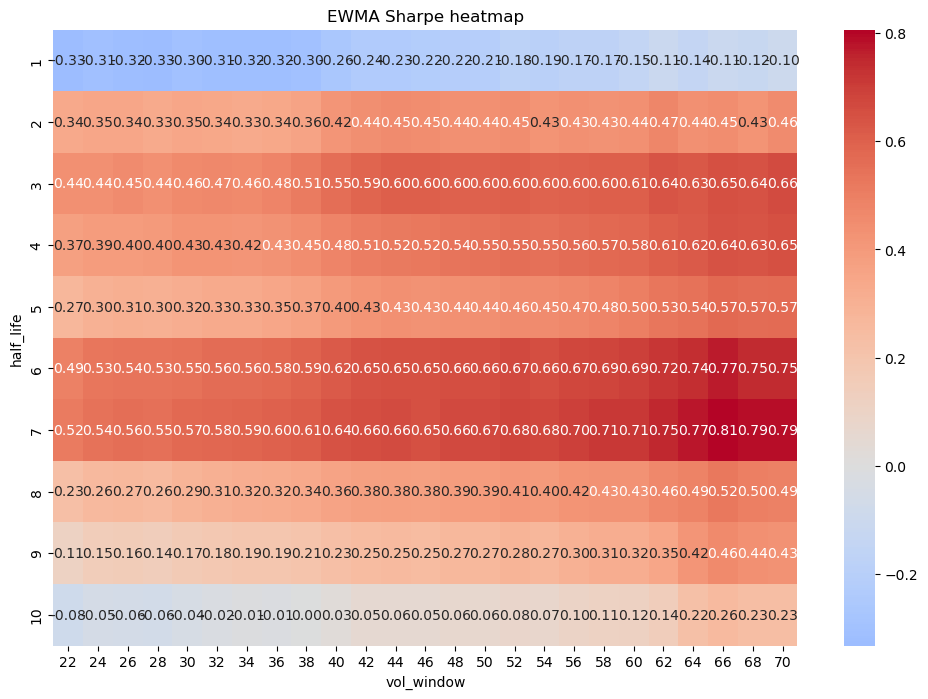

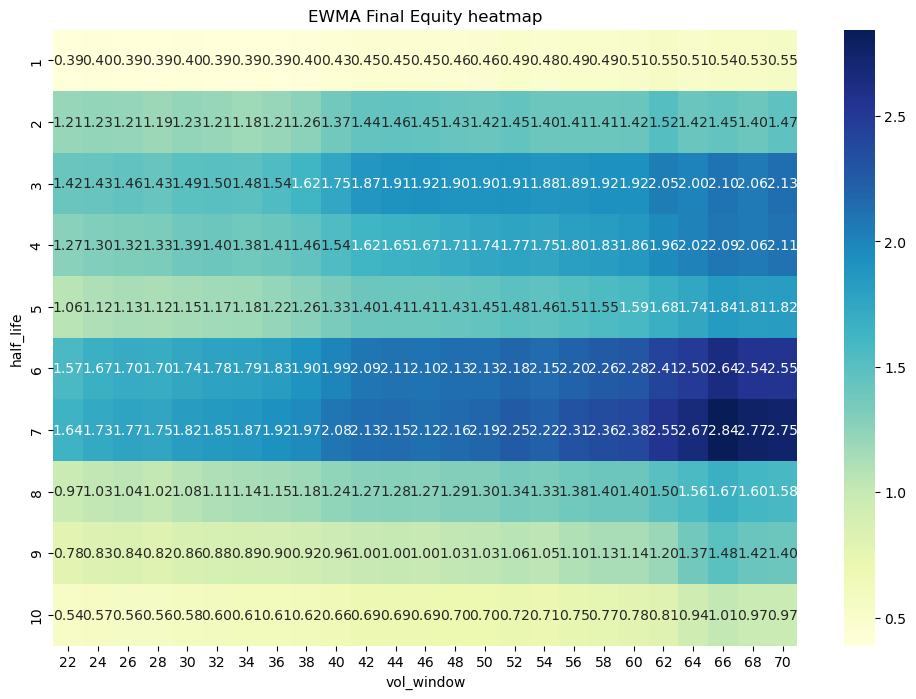

In [62]:

half_grid = [1,2,3,4,5,6,7,8,9,10]
vol_grid = [22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70]

# Results matrices: rows -> half_grid, cols -> vol_grid
results = np.full((len(half_grid), len(vol_grid)), np.nan, dtype=float)
results_equity = np.full((len(half_grid), len(vol_grid)), np.nan, dtype=float)

# Store full curves for reuse (avoid recomputation later)
equity_curves = {}   # key: (half_life, vol_window) -> pd.Series (equity)
return_series = {}   # key: (half_life, vol_window) -> pd.Series (daily returns)

# Reuse common parameters from notebook: volume_percentile, momentum_percentile, rolling_volume_matrix, price, btc_90d_return
for i_h, hl in enumerate(half_grid):
    # TEMP: fix EWMA warm-up to 60 bars for apples-to-apples comparison
    ewma_warm = 60
    ewma_sig = ewma_momentum(price, half_life=hl, warmup_bars=ewma_warm)

    for j_v, vw in enumerate(vol_grid):
        vol = price.pct_change(fill_method=None).rolling(vw).std()

        # warm-up n: ensure we have both momentum and ewma warmup satisfied
        n_simple = max(momentum_periods) + 1 if non_overlapping else max(momentum_periods)
        n = max(n_simple, ewma_warm)

        port_returns = []
        for t in range(n, len(price) - 1):
            # BTC Market filter (optional): hold cash if BTC 90-day return negative
            if use_btc_filter and (not pd.isna(btc_90d_return.iloc[t])) and (btc_90d_return.iloc[t] < 0):
                port_returns.append(0.0)
                continue

            current_volumes = rolling_volume_matrix.iloc[t].dropna()
            if len(current_volumes) == 0:
                port_returns.append(0.0); continue

            n_universe = max(1, int(len(current_volumes) * volume_percentile))
            top_volume_tickers = current_volumes.nlargest(n_universe).index

            row = ewma_sig.iloc[t]  # EWMA signature at date t
            filtered = row.reindex(top_volume_tickers).dropna()
            if len(filtered) == 0:
                port_returns.append(0.0); continue

            k = max(1, int(len(filtered) * momentum_percentile))
            longs = filtered.nlargest(k).index
            shorts = filtered.nsmallest(k).index

            long_vols = vol.iloc[t].reindex(longs).dropna()
            short_vols = vol.iloc[t].reindex(shorts).dropna()
            if len(long_vols) == 0 or len(short_vols) == 0:
                port_returns.append(0.0); continue

            lw = (1.0 / long_vols); sw = (1.0 / short_vols)
            lw = lw / lw.sum() * 0.5; sw = sw / sw.sum() * 0.5

            long_r = 0.0; short_r = 0.0
            for coin in lw.index:
                p0 = price[coin].iat[t]; p1 = price[coin].iat[t+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r += lw[coin] * coin_return
            for coin in sw.index:
                p0 = price[coin].iat[t]; p1 = price[coin].iat[t+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r += sw[coin] * coin_return

            portfolio_return = long_r - short_r - 0.0005
            port_returns.append(portfolio_return)

        daily = np.array(port_returns, dtype=float)
        if daily.size == 0 or np.nanstd(daily, ddof=1) == 0:
            sharpe = np.nan
        else:
            sharpe = (np.nanmean(daily) / np.nanstd(daily, ddof=1)) * np.sqrt(365)

        results[i_h, j_v] = sharpe

        # Final equity (starting equity = 1.0) for this parameter pair and store full curves
        if daily.size == 0:
            final_equity = np.nan
            ret_s = pd.Series(dtype=float)
            eq_s = pd.Series(dtype=float)
        else:
            mask = ~np.isnan(daily)
            if mask.sum() == 0:
                final_equity = np.nan
                ret_s = pd.Series(dtype=float)
                eq_s = pd.Series(dtype=float)
            else:
                final_equity = float(np.prod(1.0 + daily[mask]))
                dates = price.index[n+1: n+1+daily.size]
                ret_s = pd.Series(daily, index=dates, name="return")
                eq_s = (1.0 + ret_s).cumprod().rename("equity")
        results_equity[i_h, j_v] = final_equity
        # Save into dicts for reuse
        equity_curves[(hl, vw)] = eq_s
        return_series[(hl, vw)] = ret_s

# Plot interactive 3D surface (half-life on X, vol_window on Y, Sharpe on Z) using Plotly

X, Y = np.meshgrid(half_grid, vol_grid)
Z = results.T  # transpose so shapes align: Z.shape == X.shape
# Create a Plotly surface (interactive) — x=half_life, y=vol_window, z=Sharpe
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', colorbar=dict(title='Sharpe'))])
fig.update_layout(title='EWMA half-life vs vol_window: Annualized Sharpe (interactive)', width=1200, height=900, autosize=False,
                  margin=dict(l=10, r=10, t=50, b=10),
                  scene=dict(xaxis_title='half_life', yaxis_title='vol_window', zaxis_title='Annualized Sharpe'))
fig.show()

# Also show a larger heatmap (rows=half_life, cols=vol_window) for quick scanning
df_sharpe = pd.DataFrame(results, index=half_grid, columns=vol_grid)
plt.figure(figsize=(12,8))
sns.heatmap(df_sharpe, annot=True, fmt='.2f', cmap='coolwarm', center=0, annot_kws={'size':10})
plt.xlabel('vol_window')
plt.ylabel('half_life')
plt.title('EWMA Sharpe heatmap')
plt.show()

# Plot interactive 3D surface for Final Equity
Z_eq = results_equity.T
fig_eq = go.Figure(data=[go.Surface(x=X, y=Y, z=Z_eq, colorscale='Plasma', colorbar=dict(title='Final Equity'))])
fig_eq.update_layout(title='EWMA half-life vs vol_window: Final Equity (interactive)', width=1200, height=900, autosize=False,
                     margin=dict(l=10, r=10, t=50, b=10),
                     scene=dict(xaxis_title='half_life', yaxis_title='vol_window', zaxis_title='Final Equity'))
fig_eq.show()

# Heatmap for Final Equity (larger)
df_eq = pd.DataFrame(results_equity, index=half_grid, columns=vol_grid)
plt.figure(figsize=(12,8))
sns.heatmap(df_eq, annot=True, fmt='.2f', cmap='YlGnBu', annot_kws={'size':10})
plt.xlabel('vol_window')
plt.ylabel('half_life')
plt.title('EWMA Final Equity heatmap')
plt.show()

In [63]:
# Interactive plot: pick (half_life, vol_window) and show the precomputed equity curve
# This uses equity_curves and return_series created by the sweep cell above — no recomputation.

import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go

if 'equity_curves' not in globals() or 'return_series' not in globals() or len(equity_curves) == 0:
    print("Please run the parameter sweep cell first to populate equity_curves and return_series.")
else:
    # Build dropdown choices from the existing keys
    keys = sorted(list(equity_curves.keys()))  # list of (half_life, vol_window)
    # Default to the middle of the grid if possible
    default_idx = len(keys) // 2

    hl_values = sorted({k[0] for k in keys})
    vw_values = sorted({k[1] for k in keys})

    hl_dropdown = widgets.Dropdown(options=hl_values, value=hl_values[min(default_idx, len(hl_values)-1)], description='half_life')
    vw_dropdown = widgets.Dropdown(options=vw_values, value=vw_values[min(default_idx, len(vw_values)-1)], description='vol_window')

    def plot_from_cache(half_life, vol_window):
        key = (half_life, vol_window)
        eq = equity_curves.get(key, None)
        ret = return_series.get(key, None)
        if eq is None or ret is None or eq.empty:
            print("No cached equity curve for this parameter pair (maybe insufficient data). Try another.")
            return
        # Compute Sharpe for display
        r = ret.values
        if r.size == 0 or np.nanstd(r, ddof=1) == 0:
            sharpe = np.nan
        else:
            sharpe = (np.nanmean(r) / np.nanstd(r, ddof=1)) * np.sqrt(365)

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=eq.index, y=eq.values, mode='lines', name='Equity'))
        fig.update_layout(
            title=f"Equity curve — half_life={half_life}, vol_window={vol_window} | Sharpe={sharpe:.2f}",
            xaxis_title='Date',
            yaxis_title='Equity',
            hovermode='x unified'
        )
        fig.show()

    ui = widgets.HBox([hl_dropdown, vw_dropdown])
    out = widgets.interactive_output(plot_from_cache, {'half_life': hl_dropdown, 'vol_window': vw_dropdown})
    display(ui, out)

Output()